# Interpolating between Images with a Wasserstein Autoencoder


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch04_AE/ec04_B_wae_fashionmnist/fashionmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that trains a Wasserstein autoencoder on the Fashion-MNIST images and then uses the trained autoencoder to interpolate between Fashion-MNIST images moving in the latent space.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 4-B from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the Fashion-MNIST Dataset

The Fashion-MNIST dataset, created by Zalando, provides a new twist on the classic MNIST digit classification task. It consists of a training set with 60,000 images and a test set with 10,000 images. Each example is a 28 by 28 grayscale image, labeled across 10 different clothing and accessory categories.

Import the Fashion-MNIST dataset ...

In [2]:
import os
import deeptrack as dt

if not os.path.exists("FashionMNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/FashionMNIST_dataset")

data_dir = "FashionMNIST_dataset"
train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

print(f"Number of train images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Number of train images: 60000
Number of test images: 10000


... define the labels the classes of the Fashion-MNIST images ...

In [3]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
           "Shirt", "Sneaker", "Bag", "Ankle boot"]

... create an image pipeline and a label pipeline ...

In [4]:
import torch

image_pip = (dt.LoadImage(files.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float))
label_pip = dt.Value(files.label_name[0]) >> int

... and some of the Fashio-MNIST images.

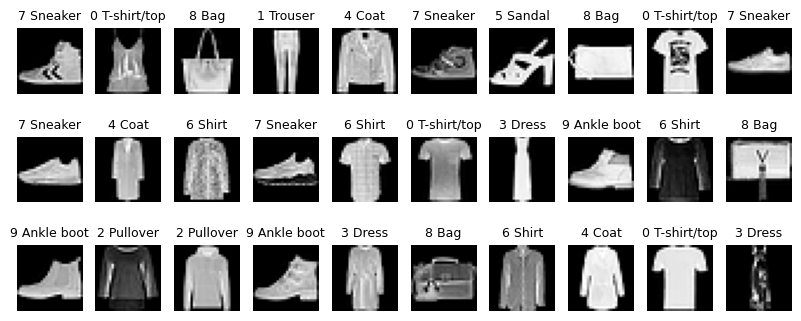

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 4)))
for ax, train_file in zip(axs.ravel(),
                          np.random.choice(train_files, axs.size)):
    image, label = (image_pip & label_pip)(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)
    ax.set_axis_off()
plt.show()

## Training the Wasserstein Autoencoder

Define the Wasserstein autoencoder ...

In [6]:
import deeplay as dl

wae = dl.WassersteinAutoEncoder(
    channels=[32, 64, 128], latent_dim=20,
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"),
).create()

print(wae)

WassersteinAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU()
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): Identity()
        (normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_enc): Linear(in_features=6272, out_features=20, bias=True)
  (fc_dec): Linear(in_features=20, 

... define the dataset and the data loader ...

In [7]:
train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=train_files)
train_loader = dl.DataLoader(train_dataset, batch_size=128, shuffle=True)

... train the Wasserstein autoencoder ...

In [8]:
wae_trainer = dl.Trainer(max_epochs=10)
wae_trainer.fit(wae, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder             │ ConvolutionalEncoder2d │ 93.1 K │ train │
│ 1 │ fc_enc              │ Linear                 │  125 K │ train │
│ 2 │ fc_dec              │ Linear                 │  131 K │ train │
│ 3 │ decoder             │ ConvolutionalDecoder2d │ 92.7 K │ train │
│ 4 │ reconstruction_loss │ MSELoss                │      0 │ train │
│ 5 │ train_metrics       │ MetricCollection       │      0 │ train │
│ 6 │ val_metrics         │ MetricCollection       │      0 │ train │
│ 7 │ test_metrics        │ MetricCollection       │      0 │ train │
│ 8 │ optimizer           │ Adam                   │      0 │ train │
└───┴─────────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 443 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 443 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 36                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


... and it in evaluation mode.

In [9]:
wae.eval();

## Reconstructing the Fashion-MNIST Images

Reconstruct some images with the trained Wasserstein autoencoder.

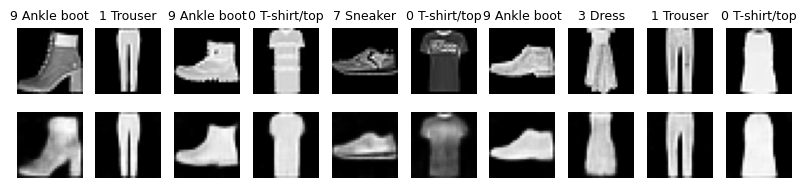

In [10]:
fig, axs = plt.subplots(2, 10, figsize=((10, 2)))
for i, test_file in enumerate(np.random.choice(test_files, 10)):
    image, label = (image_pip & label_pip)(test_file)
    axs[0, i].imshow(image.squeeze(), cmap="gray")
    axs[0, i].set_title(f"{int(label)} {classes[int(label)]}", fontsize=9)
    axs[0, i].set_axis_off()

    reconstructed_image, _ = wae(image.unsqueeze(0))
    axs[1, i].imshow(reconstructed_image.detach().squeeze(), cmap="gray")
    axs[1, i].set_axis_off()
plt.show()

## Generating Images with the Decoder

Genrate new images using the decoder.

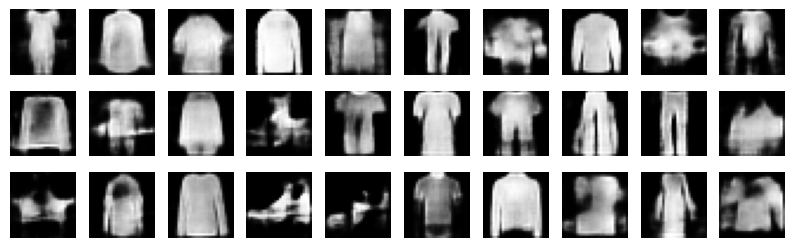

In [11]:
images = wae.decode(torch.randn(30, wae.latent_dim)).detach().squeeze()

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, image in zip(axs.ravel(), images):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()
plt.show()

## Morphing Images by Moving in the Latent Space

Generate the intermediate images by interpolating between the latent vectors of two images.

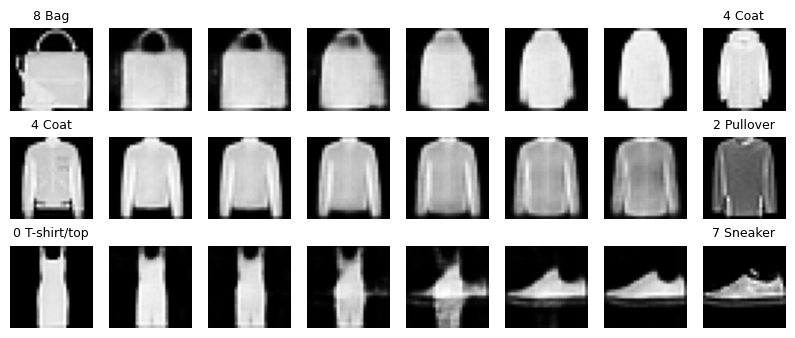

In [12]:
steps = 6

fig, axs = plt.subplots(3, steps + 2, figsize=((10, 4)))
for i, _ in enumerate(axs):
    test_file_0, test_file_1 = np.random.choice(test_files, 2)

    image_0, label_0 = (image_pip & label_pip)(test_file_0)
    z_0 = wae.encode(image_0.unsqueeze(0))

    image_1, label_1 = (image_pip & label_pip)(test_file_1)
    z_1 = wae.encode(image_1.unsqueeze(0))

    axs[i, 0].imshow(image_0.squeeze(), cmap="gray")
    axs[i, 0].set_title(f"{int(label_0)} {classes[int(label_0)]}", fontsize=9)
    axs[i, 0].set_axis_off()

    for step in range(steps):
        z_step = z_0 + (z_1 - z_0) * step / (steps - 1)
        image_step = wae.decode(z_step).detach()
        axs[i, step + 1].imshow(image_step.squeeze(), cmap="gray")
        axs[i, step + 1].set_axis_off()
        

    axs[i, -1].imshow(image_1.squeeze(), cmap="gray")
    axs[i, -1].set_title(f"{int(label_1)} {classes[int(label_1)]}", fontsize=9)
    axs[i, -1].set_axis_off()
plt.show()